# Prediction of Singapore's housing price using simple regression based models
## Exploratory Data Analysis notebook

This project is about the prediction of resale price of a house located in singapore, using simple regression model.   
This notebook is only for the purpose of doing Exploratory Data Analysis (EDA).

content:  
1. [Problem Statement](#Problem-Statement)
2. [Data Import](#Data-Import)
3. [Missing Values](#Missing-Values)
4. [Data Distribution](#Data-Distribution)
5. [Outliers](#Outliers)
6. [Evaluation based on EDA](#Evaluation-based-on-EDA)

## Problem Statement 

The goal of this project is to build a regression model, using data contained in the [datasets](../datasets) folder. The model should be able to make an accurate prediction of the resale price (`resale_price`) of the house, for every house id (`Id`) that appeared in the [test set](../datasets/test.csv).  
Success will be evaluated based on common evaluation metrics such as Mean Absolute Error (MAE) and Mean Square Error (MSE), apart from scores.

Motivation:  
While this is a toy project for the purpose of learning, it shows the importance of prediction models.  
House owners who are looking to sale their property, property agents, those seeking to purchase a house, all stand to benefit from this model.  

## Data Import

Here, the neccessary libraries, dependencies and data are imported.

In [64]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display


pd.options.display.max_rows = 100
pd.options.display.max_columns = 80

If simply use `.read_csv()` method from Pandas, a warning will appear.  

`DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.`  
`train = pd.read_csv('../datasets/train.csv')`   

In [2]:
sample = pd.read_csv('../datasets/sample_sub_reg.csv')
train = pd.read_csv('../datasets/train.csv')

/tmp/ipykernel_1710/3171447742.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../datasets/train.csv')


In [3]:
# check the shape of the data imported
train.shape

(150634, 77)

In [4]:
# find the name of the column with problem
train.columns[41]

'postal'

In [5]:
# Take a look at the column with warning
train.postal.head()

0    382003
1    570153
2    651289
3    570232
4    760876
Name: postal, dtype: object

In [6]:
# From output above, the main dtpye is object. Upon checking (and guessing from convention), it is of str type.
# Check what is the total number of data points that is not in str datatype.
not_str = [x for x in train.postal if type(x) != str]
# Check what type can these data points be.
print(type(not_str[0]))
print(len(not_str))
# Check are there any more data types
not_int = [s for s in not_str if type(s) != int]
print(len(not_int))

<class 'int'>
35946
0


In [7]:
# Check are there any other types of data I have not considered.
is_str = [x for x in train.postal if type(x) == str]
len(is_str)

114688

## Missing Values

In [8]:
# While coding, I discovered that some of the 'postal' have 'NIL' in the entry
nil_lst = train['postal'].loc[train['postal'] == 'NIL']
print(len(nil_lst))
print(len(nil_lst)/150634*100)

33
0.021907404702789544


In [9]:
# # convert 'NIL' to None/ Nan type
# train.loc[train['postal'] == 'NIL'] = None

In [10]:
# # convert str to int
# train.postal = [int(x) if type(x) == str else x for x in train.iloc[:,42]]

In [11]:
# train['postal'].isnull().sum()

In [12]:
not_str = [x for x in train.postal if type(x) != str]
# Check what type can these data points be.
print(type(not_str[0]))
print(len(not_str))

<class 'int'>
35946


In [13]:
# 114688 + 35946 == 150634. There are only 2 data types in column 42. int and str.
# define function to convert all string to int. 

def convert_dtype(x):
    '''This function convert a single numerical str to int
    Args:
        x (str): numerical str that can be cast to int
    Returns:
        x (int): converted x in int datatype
    '''
    if (type(x) != int):
        try:
            return int(x)
        except:
            if x == 'NIL':
                return -1
    else:
        return x

# apply is very slow
train['postal']=train['postal'].apply(convert_dtype)

In [14]:
# It is VERY important to note that I have converted all 'NIL' to -1
# so I dont have to convert the datatype for postal code from float to int again later.
# -1 is selected because there's no postal code with -1.
train['postal'].isnull().sum()

0

In [15]:
# find percentage of data missing
train.isnull().sum()/150634*100

id                            0.000000
Tranc_YearMonth               0.000000
town                          0.000000
flat_type                     0.000000
block                         0.000000
street_name                   0.000000
storey_range                  0.000000
floor_area_sqm                0.000000
flat_model                    0.000000
lease_commence_date           0.000000
resale_price                  0.000000
Tranc_Year                    0.000000
Tranc_Month                   0.000000
mid_storey                    0.000000
lower                         0.000000
upper                         0.000000
mid                           0.000000
full_flat_type                0.000000
address                       0.000000
floor_area_sqft               0.000000
hdb_age                       0.000000
max_floor_lvl                 0.000000
year_completed                0.000000
residential                   0.000000
commercial                    0.000000
market_hawker            

<AxesSubplot: >

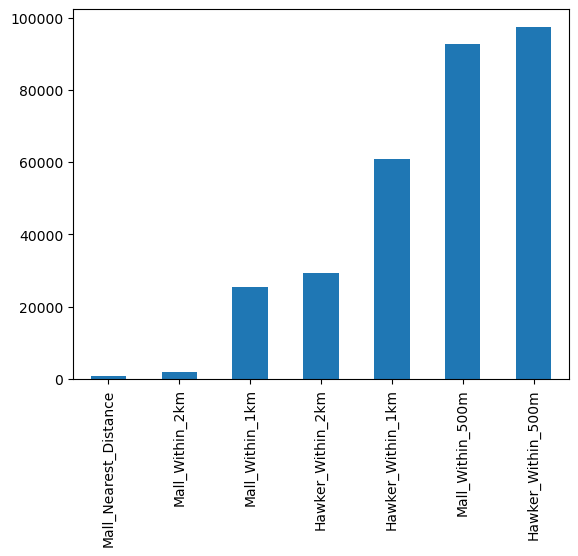

In [16]:
# Graphically

missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are a total of 7 + 1 features with `null` values in this dataset.  
The +1 is the postal code feature, where `null` was converted to `-1`. It have 33 entries, or 0.02% fo the data.  
The other 7 features with `null` are:  

|Fetures|Percentage|
|-------|----------|
|Mall_Nearest_Distance|       0.5503|  
|Mall_Within_500m|             61.5990|  
|Mall_Within_1km|              16.8793|  
|Mall_Within_2km|              1.2879|  
|Hawker_Within_500m|           64.6534|  
|Hawker_Within_1km|            40.4079|  
|Hawker_Within_2km|            19.3861|   

Since only 0.5% of `Mall_Nearest_Distance` is `null`, drop the `null` together with `postal` feature.   
Worst case senario, I am lose 0.52% of the data.  

As for the other 6 features, the `Mall_Nearest_Distance` and `Hawker_Nearest_Distance` already covered this information.  
The columns can be removed, as they are essentially the same information and they are obvious correlated. Which is not ideal for regression models.

In [17]:
train.drop(columns=['Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 
'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km'], inplace=True)
train.shape

(150634, 71)

In [18]:
train.dropna(inplace=True)
train.shape

(149805, 71)

In [19]:
train = train[train['postal']>-1]
display(train.shape)
train.reset_index(drop=True, inplace=True)
display(train.head())

(149772, 71)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,15,25,2005,Y,N,N,N,N,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,154.753357,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,34,9,1987,Y,N,N,N,N,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,640.151925,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,24,16,1996,Y,N,N,N,N,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,1762.082341,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,29,11,1990,Y,Y,N,N,N,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,726.215262,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,34,4,1987,Y,N,N,N,N,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,1540.151439,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


With this, `null` values are removed and dataset is ready for EDA and further cleaning.  

## Data Distribution

content:  
[Value to preict](#Value-to-predict)  
[Features used for prediction](#Features-used-for-prediction)  
[Numerical features](#Numerical-features)  
[Categorical features](#Categorical-features)   

### Value-to-predict

First, take a look at the distribution of feature to be predicted, `resale_price`.

In [20]:
train.resale_price.describe()

count    1.497720e+05
mean     4.486613e+05
std      1.432260e+05
min      1.500000e+05
25%      3.460000e+05
50%      4.200000e+05
75%      5.200000e+05
max      1.258000e+06
Name: resale_price, dtype: float64

We can see the resale price have a range of 150,000 to 1,258,000 SGD.   
Mean price is at 448,661.13 SGD. While median price is at 420,000 SGD. This shows a likely right skewness.  
This also shows most houses are still affordable back then.  
However, a good property can go up to 1.258 million SGD. That IS A LOT of money.  

<Figure size 1000x3000 with 0 Axes>

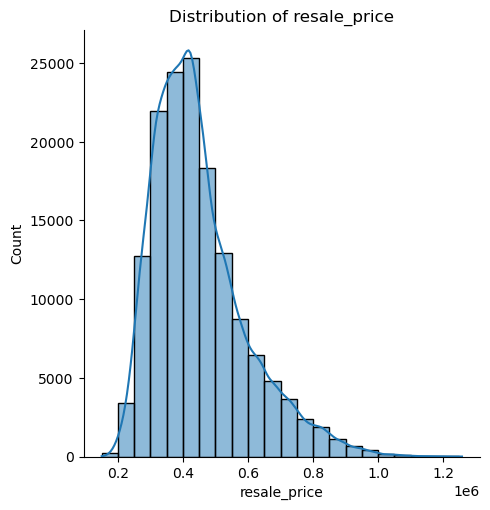

In [21]:
plt.figure(figsize = (10,30)); # plt.plot() is using plt to plot. plt.figure() is asking plt to give a canvas for drawing of anything
sns.displot(train.resale_price, kde=True, bins=list(range(150000, 1258000, 50000)))
plt.title('Distribution of resale_price');

Here, I am using a value of 50,000 per bin.  
This is becasue the default value and value of 10,000 per bin will both yeild very fine histograms which does not give a good overall representation of the distribution of the prices.   
At 50,000 per bin, that's roughly about 1 year's wage for many normal Singaporeans. This will give the rought shape of the distribution, with right ammount of details.  

From the figure above, we can see that model resale price is between 0.45 to 0.5 million SGD.   
Welp, the only thing I can say is get a girlfriend and buy early...   
Jokes aside, the defining features I can observe are:  
1. It is right skewed.
2. It deviates from normal distribution.
3. it is single peaked.

In [22]:
#skewness and kurtosis
print("Skewness: %f" % train.resale_price.skew())
print("Kurtosis: %f" % train.resale_price.kurt())

Skewness: 1.088377
Kurtosis: 1.338013


Note to self:  
Skewness:   
<img src="../img/wiki_skewness.png" width="200" height="100"></img>  
This image refers to the sample skewness, from Google.  
Skewness is a measure of the symmetry in a distribution.  A symmetrical dataset will have a skewness equal to 0.  So, a normal distribution will have a skewness of 0.   Skewness essentially measures the relative size of the two tails.   
Kurtosis:  
<img src="../img/goog_kurtosis.png" width="200" height="100"></img>  
This image refers to kurtosis of data, from Google.  
The kurtosis parameter is a measure of the combined weight of the tails relative to the rest of the distribution.  
Taken from [SPCforExcel website](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics).

Essentially, these parameters are saying `resale_price` is not normally distributed and the center of the distribution still makes a large portion of the data.

### Features used for prediction 

Next, look at the data dictionary provided in GA Singapore's kaggle to check for the meaning od eacf feature.  
With this, I can get a rough sense of should the data be included in the first place.  
As we know, multicollinearity, where several independent variables in a model are correlated, will result in poorer model performance.  
Although tideous, this can be a good time to do a preliminary seiving for what variables to keep. 

That is A LOT of work. However, I can have a better understanding of what I am dealing with.  
I can also guess on what are the more important predictors.  
Like distance to MRT, size of flat, age of flat, etc.  
I will create a deep copy of the dataset, and then start to filter out features with strong correlation.  
I then manually analyse these features, and make a decision id they are needed for making of the model.  

In [23]:
train_copy = train.copy(deep=True)

In [24]:
train_copy.shape

(149772, 71)

In [25]:
# remove resale_price from dataframe for analysis on on correlated data
train_copy.drop(columns=['resale_price'], inplace=True)

In [26]:
# take a look at pearson's r between the numerical features
corr = train_copy.corr(numeric_only=True)

In [27]:
corr.shape

(51, 51)

In [28]:
class Correaltion_Operation(object):
    """
    Class operating on corr data frame from pd.corr()
    """
    def __init__(self, corr):
        '''Initialise the object.
        
        Args:
            corr (DataFrame): correalation matrix from pandas
        '''
        self.corr = corr
    def convert_to_lower_tri(self):
        """Converts the corr matrix to lower triangular form, adds lower_tri form to object
        
        Returns:
            lower_tri_wo_dia (DataFrame): lower triangular form of corr matrix without diagonal
        """
        columns = corr.columns
        row_index = {i: col for i, col in enumerate(corr.columns)}
        corr_a = np.array(corr)
        corr_tril_indi = corr_a[np.triu_indices(corr_a.shape[0], k = 1)]
        zero_matrix = np.zeros((len(columns), len(columns)))
        zero_matrix[np.triu_indices(zero_matrix.shape[0], k=1)] = corr_tril_indi
        lower_tri_wo_dia = pd.DataFrame(zero_matrix.T, columns = corr.columns)
        lower_tri_wo_dia =  lower_tri_wo_dia.rename(index=row_index)
        self.lower_tri = lower_tri_wo_dia
        return lower_tri_wo_dia
    def find_highest_corr_pair(self, threshold):
        """Find the pair with pearson's r value above threshold
        
        Args:
            threshold (float): threshold value, above which return the name of the pair
        
        Returns:
            abv_threshold_dict (dict): dictionary of pairs with pearson's r above input threshold
        """
        abv_threshold_dict = {}
        lower_tri_wo_dia = self.convert_to_lower_tri()
        columns = lower_tri_wo_dia.columns
        rows = lower_tri_wo_dia.index
        for i, col in enumerate(columns):
            for j, row in enumerate(rows):
                if (lower_tri_wo_dia[col][row] >= threshold) | (-threshold >= lower_tri_wo_dia[col][row]): 
                    abv_threshold_dict[lower_tri_wo_dia[col][row]] = {"col": (i, col), "row": (j, row)}
        return abv_threshold_dict

In [29]:
corr_obj = Correaltion_Operation(corr)
abv_threshold_dict = corr_obj.find_highest_corr_pair(0.75)

Okay, the result is a very very very long dictionary.  
The key is the `Pearson's r` value for the pair of numerical features.  
The value is a dictionary with 2 keys in it, namely `col` and `row`.  
For each `col` and `row`, the index of the feature and name of the feature is stored in a tuple.  
```bash
pearson_r_value:{
    col: (idx, feature1_name)
    row: (idx, feature2_name)
    }
```
Note: As the `corr` matrix is a square symmetrical matrix, meaning A.T = A, n = m, row index and colmun index is the same.

In [30]:
for one_dict in abv_threshold_dict:
    print(f"for feature: '{abv_threshold_dict[one_dict]['col'][1]}' and feature: '{abv_threshold_dict[one_dict]['row'][1]}', the r value is {np.round(one_dict, 2)}")

for feature: 'id' and feature: 'floor_area_sqm', the r value is 0.76
for feature: 'id' and feature: 'floor_area_sqft', the r value is 0.76
for feature: 'floor_area_sqm' and feature: 'floor_area_sqft', the r value is 1.0
for feature: 'lease_commence_date' and feature: 'hdb_age', the r value is -1.0
for feature: 'lease_commence_date' and feature: 'year_completed', the r value is 0.99
for feature: 'mid_storey' and feature: 'lower', the r value is 1.0
for feature: 'mid_storey' and feature: 'upper', the r value is 1.0
for feature: 'mid_storey' and feature: 'mid', the r value is 1.0
for feature: 'lower' and feature: 'upper', the r value is 1.0
for feature: 'lower' and feature: 'mid', the r value is 1.0
for feature: 'upper' and feature: 'mid', the r value is 1.0
for feature: 'hdb_age' and feature: 'year_completed', the r value is -0.99
for feature: 'postal' and feature: 'Latitude', the r value is 0.83
for feature: 'postal' and feature: 'mrt_latitude', the r value is 0.83
for feature: 'postal'

Anyways, it is a long list to go through mannually, and a csv documnet is used to keep tarck.  
If keep, then assign 1, else assign 0.  
A screenshot is shown below.  
<img src="../img/date_dict.png"></img>  
For further elaboration on why the feature is dropped, refer to remarks in `data_dic_ana.csv`

Below is an example of why some of possible collinearity in the categotical feature.

In [31]:
train_copy.planning_area.unique()

array(['Kallang', 'Bishan', 'Bukit Batok', 'Yishun', 'Geylang', 'Hougang',
       'Bedok', 'Sengkang', 'Tampines', 'Serangoon', 'Bukit Merah',
       'Bukit Panjang', 'Woodlands', 'Jurong West', 'Toa Payoh',
       'Choa Chu Kang', 'Sembawang', 'Novena', 'Ang Mo Kio', 'Pasir Ris',
       'Clementi', 'Punggol', 'Jurong East', 'Rochor', 'Queenstown',
       'Bukit Timah', 'Outram', 'Tanglin', 'Marine Parade',
       'Western Water Catchment', 'Downtown Core', 'Changi'], dtype=object)

In [32]:
train_copy.town.unique()

array(['KALLANG/WHAMPOA', 'BISHAN', 'BUKIT BATOK', 'YISHUN', 'GEYLANG',
       'HOUGANG', 'BEDOK', 'SENGKANG', 'TAMPINES', 'SERANGOON',
       'BUKIT MERAH', 'BUKIT PANJANG', 'WOODLANDS', 'JURONG WEST',
       'TOA PAYOH', 'CHOA CHU KANG', 'SEMBAWANG', 'ANG MO KIO',
       'PASIR RIS', 'CLEMENTI', 'PUNGGOL', 'JURONG EAST', 'CENTRAL AREA',
       'QUEENSTOWN', 'BUKIT TIMAH', 'MARINE PARADE'], dtype=object)

As can be seen, `town` is a subset of `planning_area`. Hence `planning_area` is kept and `town` is removed.

In [33]:
# Import the result of mannual analysis.
data_dict_ana = pd.read_csv('../datasets/data_dictionary_analysis.csv')
# Display the entire data dictionary
data_dict_ana

,no,feature,description,keep,data_type,missing_data,remarks
0,1,resale_price,the property's sale price in Singapore dollars...,0,numerical,NaN,To predict this value
1,2,Tranc_YearMonth,"year and month of the resale transaction, e.g....",0,Categorical,NaN,Used in tran_year and tran_month
2,3,town,"HDB township where the flat is located, e.g. B...",0,Categorical,NaN,Related to planning area
3,4,flat_type,"type of the resale flat unit, e.g. 3 ROOM",1,Categorical,NaN,"Flat_type ""3 ROOM"" has -0.5 correlation with r..."
4,5,block,"block number of the resale flat, e.g. 454",0,Categorical,NaN,In postal code
5,6,street_name,"street name where the resale flat resides, e.g...",0,Categorical,NaN,"Too many unique values, around 500. Related wi..."
6,7,storey_range,"floor level (range) of the resale flat unit, e...",0,Categorical,NaN,Using mid storey
7,8,floor_area_sqm,floor area of the resale flat unit in square m...,1,numerical,NaN,Old flats has larger area
8,9,flat_model,"HDB model of the resale flat, e.g. Multi Gener...",1,Categorical,NaN,"Flat model ""NEW GENERATION"" has negative 0.28 ..."
9,10,lease_commence_date,commencement year of the flat unit's 99-year l...,0,Date,NaN,"Used to calculate the 99 years, it can be late..."


In [34]:
# filter the manual analysis results and extract out what to drop.
colmuns_2_drop = data_dict_ana.feature[1:].loc[data_dict_ana.keep[1:] == 0]

In [35]:
len(colmuns_2_drop)

61

In [36]:
colmuns_2_keep = data_dict_ana.feature[1:].loc[data_dict_ana.keep[1:] == 1]
colmuns_2_keep

3                   flat_type
7              floor_area_sqm
8                  flat_model
10                 Tranc_Year
15                        mid
19                    hdb_age
20              max_floor_lvl
43              planning_area
44      Mall_Nearest_Distance
48    Hawker_Nearest_Distance
54       mrt_nearest_distance
56            bus_interchange
57            mrt_interchange
72               cutoff_point
76                    hdb_age
Name: feature, dtype: object

In [37]:
# convert what to drop to a list, then feed it to .drop
colmuns_2_drop = colmuns_2_drop.to_list()
alrdy_removed = ['Mall_Within_500m', 'Mall_Within_1km', 'Hawker_Within_500m', 'Hawker_Within_1km', 'Mall_Within_2km', 'Hawker_Within_2km']
for feature in alrdy_removed:
    colmuns_2_drop.remove(feature)
train.drop(columns=colmuns_2_drop, inplace=True)
train.head()

,id,flat_type,floor_area_sqm,flat_model,resale_price,Tranc_Year,mid,hdb_age,max_floor_lvl,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_interchange,mrt_interchange,cutoff_point
0,88471,4 ROOM,90.0,Model A,680000.0,2016,11,15,25,Kallang,1094.090418,154.753357,330.083069,0,0,224
1,122598,5 ROOM,130.0,Improved,665000.0,2012,8,34,9,Bishan,866.941448,640.151925,903.659703,1,1,232
2,170897,EXECUTIVE,144.0,Apartment,838000.0,2013,14,24,16,Bukit Batok,1459.579948,1762.082341,1334.251197,1,0,188
3,86070,4 ROOM,103.0,Model A,550000.0,2012,3,29,11,Bishan,950.175199,726.215262,907.453484,1,1,253
4,153632,4 ROOM,83.0,Simplified,298000.0,2017,2,34,4,Yishun,729.771895,1540.151439,412.343032,0,0,208


In [38]:
train.to_csv('../datasets/reduced_train.csv', index=False)

With this, I have decided on cutting the extra features which could lead to multicollinearity.  
Many of the redundent/ uncessary/ extra features are removed.  
The more essential/ interesting features are kept and will be used to build the model later in another [notebook](./house_reg_model.ipynb).  

In [39]:
reduced_train = pd.read_csv('../datasets/reduced_train.csv')

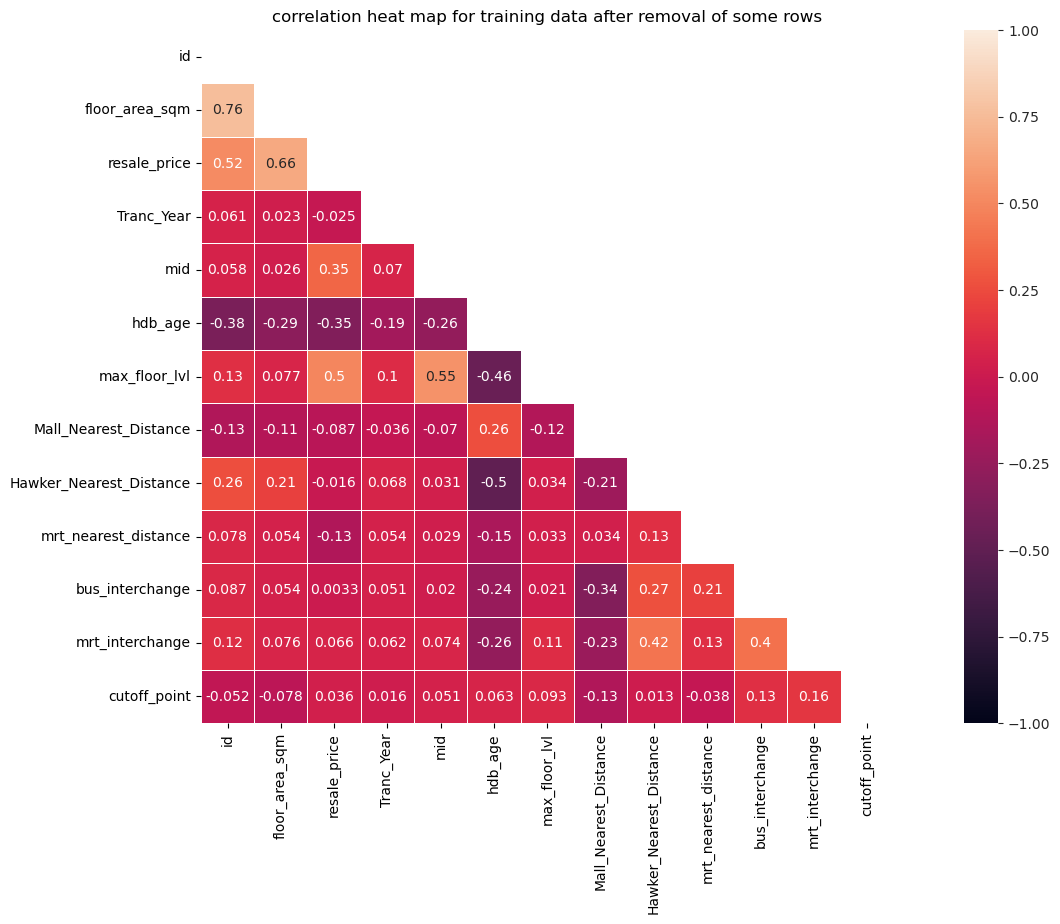

In [40]:
plt.figure(figsize = (18,9))
plt.title("correlation heat map for training data after removal of some rows")
# Get correlation of variables.
corr = reduced_train.corr(numeric_only=True)
# Set up mask to be “True” in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5)

### Numerical features

This section explores the numerical features identified that should be kept.  
EDA is done and summary statistics are provided.

In [41]:
# Find the numerical columns only
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
reduced_numeric = reduced_train.select_dtypes(include=numerics)

In [42]:
numeric_features = reduced_numeric.columns
numeric_features = list(numeric_features)
not_numeric = ['id', 'resale_price', 'bus_interchange', 'mrt_interchange', 'Tranc_Year']
for feature in not_numeric:
    numeric_features.remove(feature)
print(numeric_features)

['floor_area_sqm', 'mid', 'hdb_age', 'max_floor_lvl', 'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 'mrt_nearest_distance', 'cutoff_point']


In [43]:
class analysis_by_col(object):
    '''analyse the dataframe based on colmuns
    '''
    def __init__(self, df):
        self.df = df

class numeric_col(analysis_by_col):
    '''analyse numerical colmuns
    '''
    def __init__(self, df, num_columns):
        self.num_columns = num_columns
        super().__init__(df)
    
    def plot(self):
        '''plot graphs of resale_price vs 'numeric_feature'
        '''
        for col in self.num_columns:
            fig = plt.figure(figsize=(18,6)) 
            plt.scatter(x=reduced_train[col], y=reduced_train['resale_price'], marker='x')
            plt.xlabel(col)
            plt.ylabel('resale_price')
            plt.title('resale_price vs '+ col)
    
    def summary_statistics(self):
        '''print summary statistics of distribution of 'numeric_feature'
        '''
        display(self.df[self.num_columns].describe())
        
    def print_dist(self):
        '''print distribution of the numerical columns
        '''
        for col in self.num_columns:
            fig = plt.figure(figsize=(9,3)) 
            self.df[col].plot(kind='kde')
            plt.title('Kernel Density Function of '+ col)
            plt.xlabel(col)
            
    def print_feature_stat(self):
        '''print the skewness and kurtosis of the features
        '''
        for col in self.num_columns:
            print("For " + col +" feature: ")
            print("Skewness: %f" % reduced_train[col].skew())
            print("Kurtosis: %f" % train.resale_price.kurt())
            print("-----------------------------------")

In [44]:
# create object
numeric_columns = numeric_col(reduced_train, numeric_features)

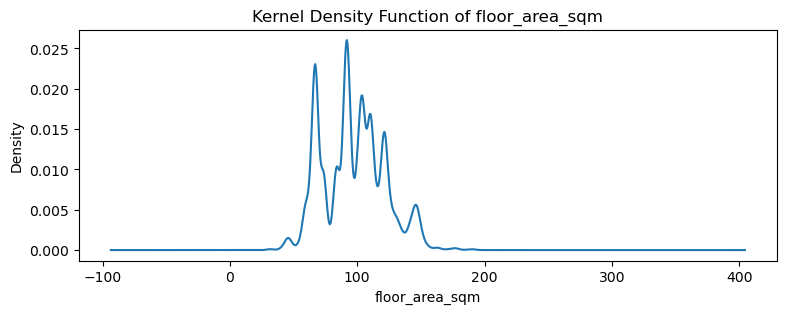

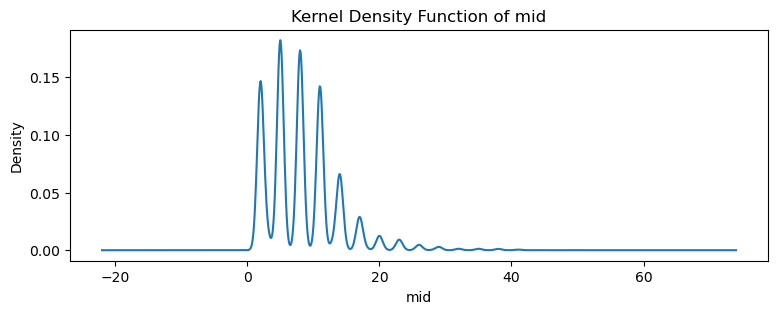

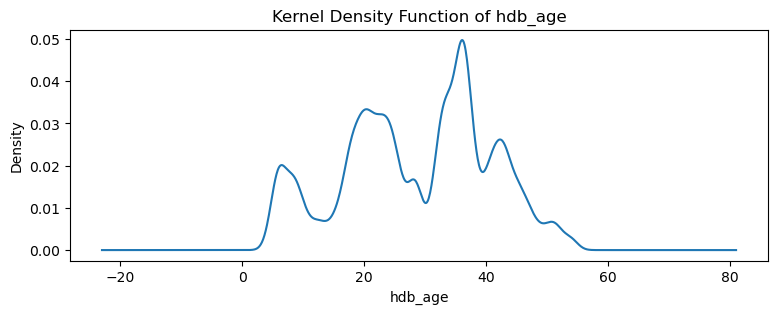

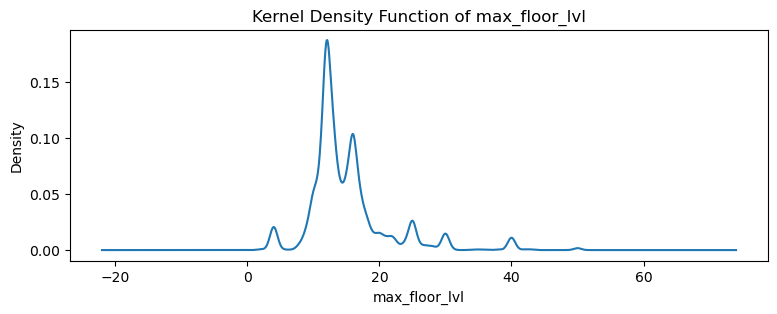

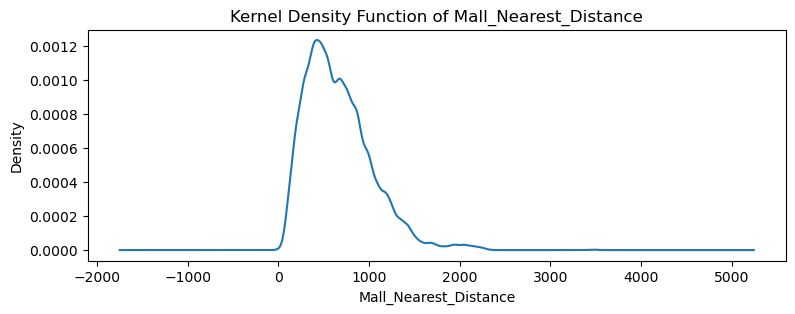

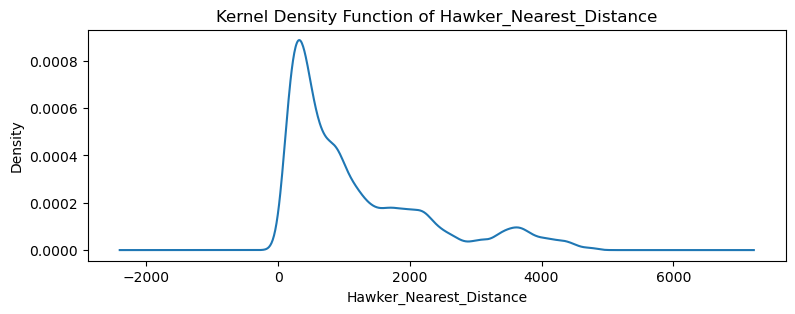

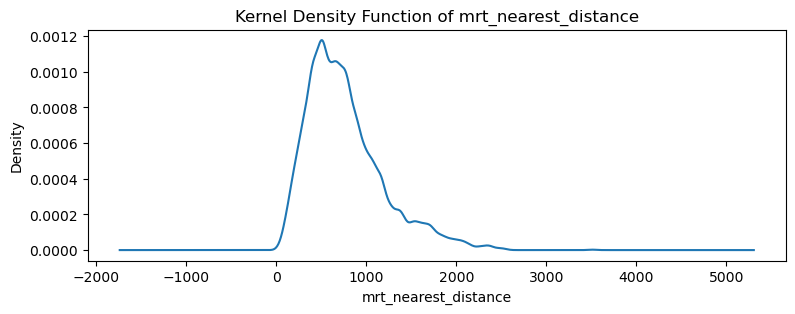

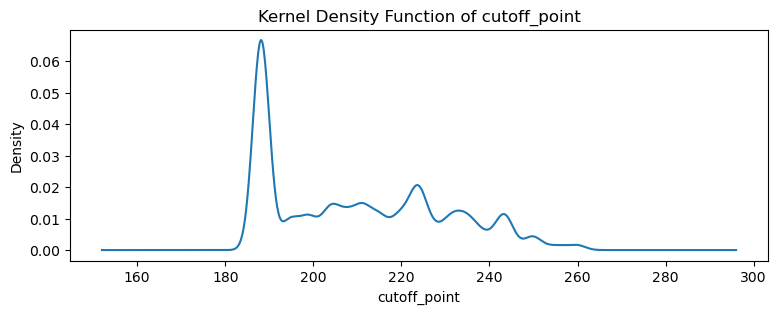

In [45]:
numeric_columns.print_dist()

In [46]:
numeric_columns.print_feature_stat()

For floor_area_sqm feature: 
Skewness: 0.270599
Kurtosis: 1.338013
-----------------------------------
For mid feature: 
Skewness: 1.542546
Kurtosis: 1.338013
-----------------------------------
For hdb_age feature: 
Skewness: -0.192282
Kurtosis: 1.338013
-----------------------------------
For max_floor_lvl feature: 
Skewness: 2.015694
Kurtosis: 1.338013
-----------------------------------
For Mall_Nearest_Distance feature: 
Skewness: 1.115887
Kurtosis: 1.338013
-----------------------------------
For Hawker_Nearest_Distance feature: 
Skewness: 1.359538
Kurtosis: 1.338013
-----------------------------------
For mrt_nearest_distance feature: 
Skewness: 1.152582
Kurtosis: 1.338013
-----------------------------------
For cutoff_point feature: 
Skewness: 0.440996
Kurtosis: 1.338013
-----------------------------------


In [47]:
numeric_columns.summary_statistics()

,floor_area_sqm,mid,hdb_age,max_floor_lvl,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,cutoff_point
count,149772.000000,149772.000000,149772.000000,149772.000000,149772.000000,149772.000000,149772.000000,149772.000000
mean,97.225294,8.263247,28.684474,15.107917,664.293227,1167.437622,764.101035,210.127093
std,24.440481,5.482350,12.041561,6.195142,368.761294,1071.111442,429.125107,20.005313
min,31.000000,2.000000,3.000000,2.000000,0.000000,1.873295,21.971410,188.000000
25%,75.000000,5.000000,20.000000,12.000000,391.473823,371.492143,458.233358,188.000000
50%,95.000000,8.000000,31.000000,13.000000,602.838007,776.103172,681.890425,208.000000
75%,112.000000,11.000000,37.000000,16.000000,868.818288,1669.780674,974.316272,224.000000
max,280.000000,50.000000,55.000000,50.000000,3496.402910,4816.062542,3544.504228,260.000000


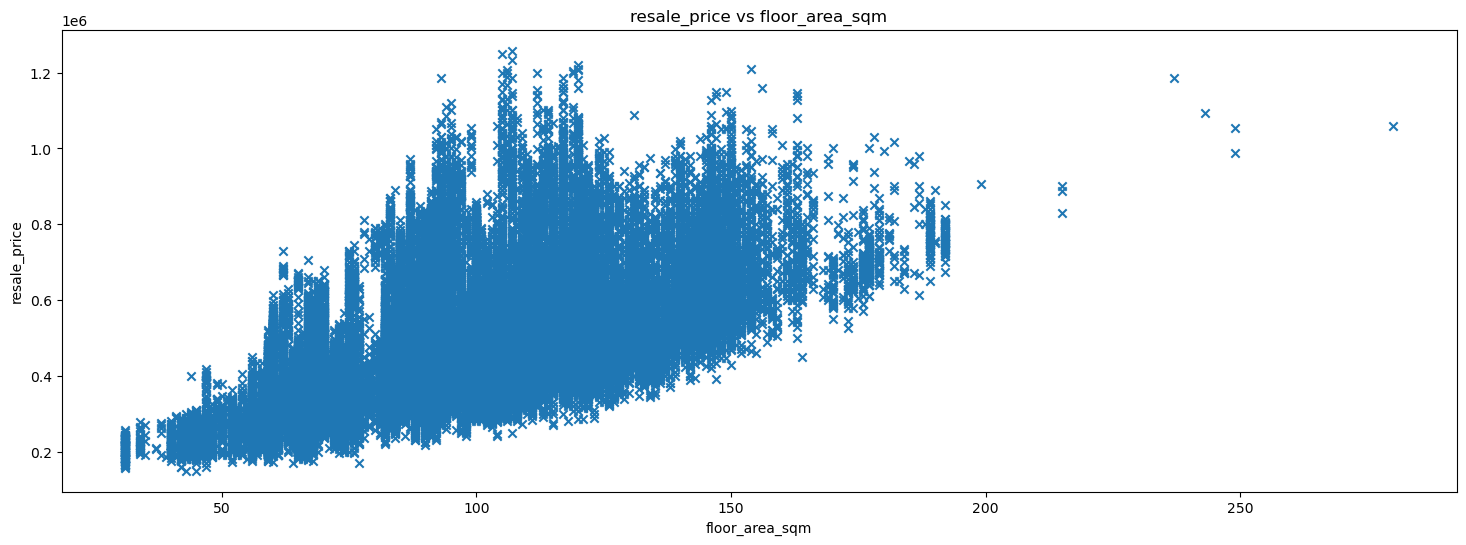

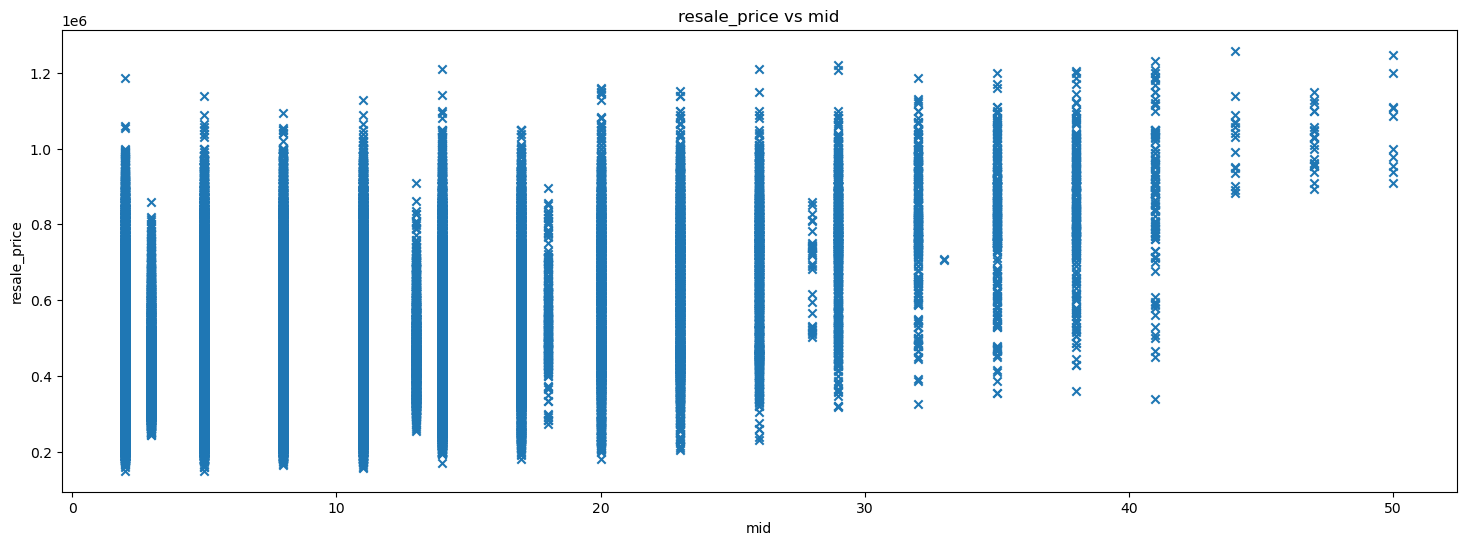

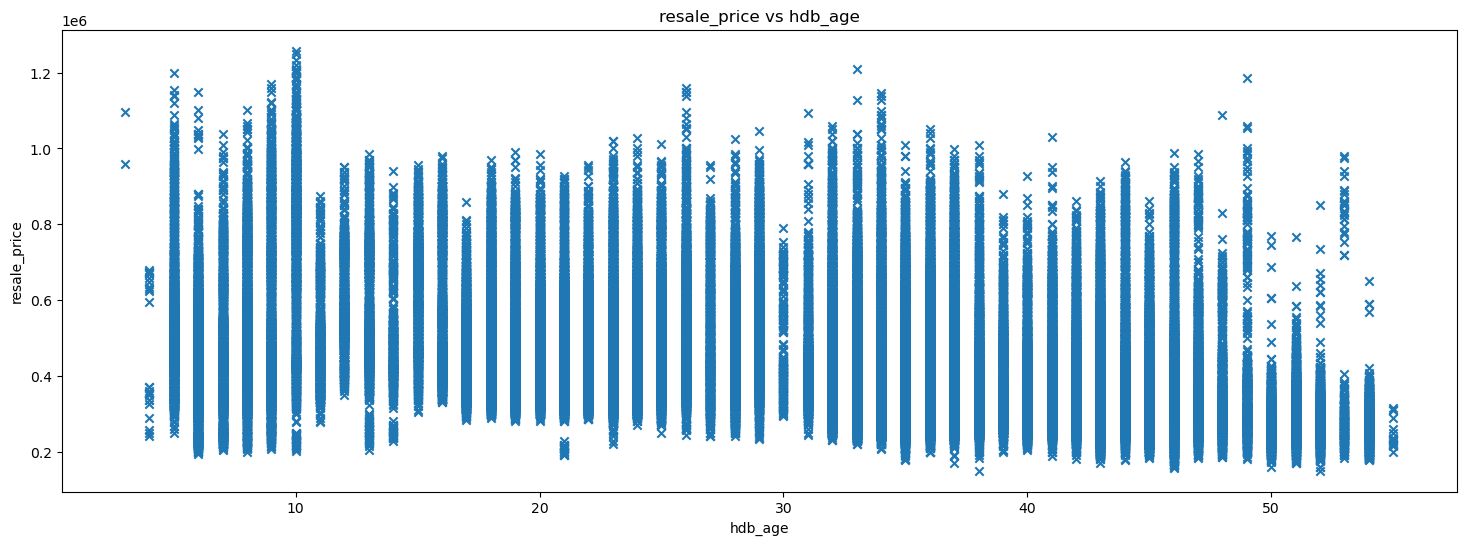

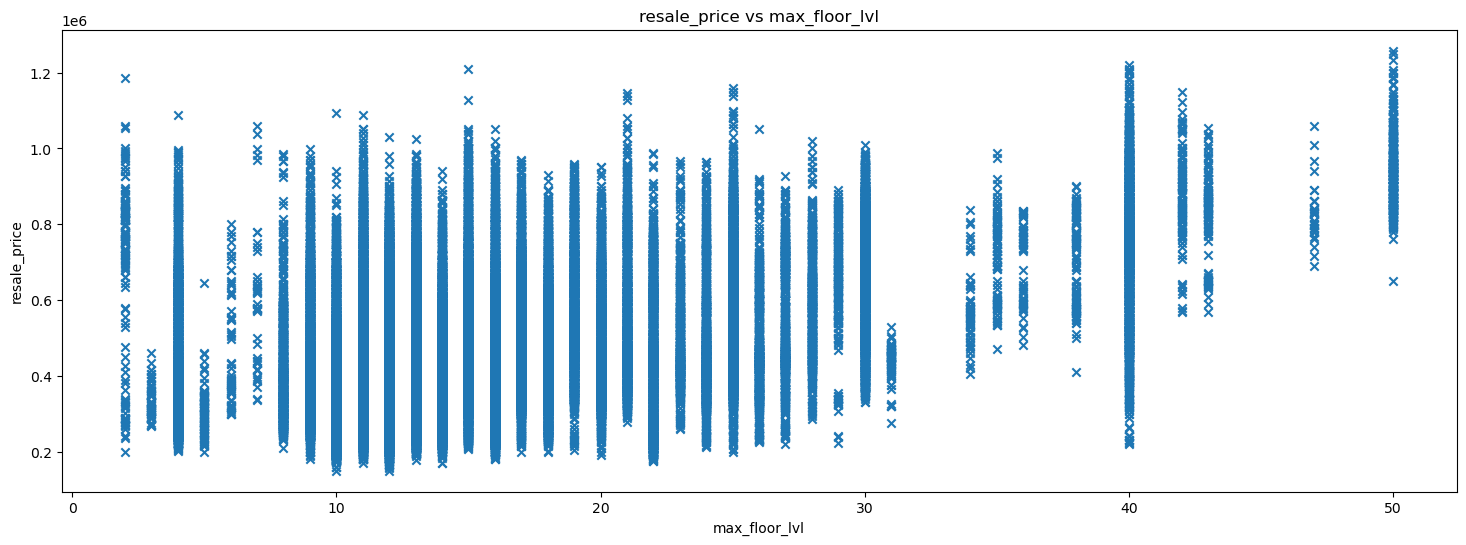

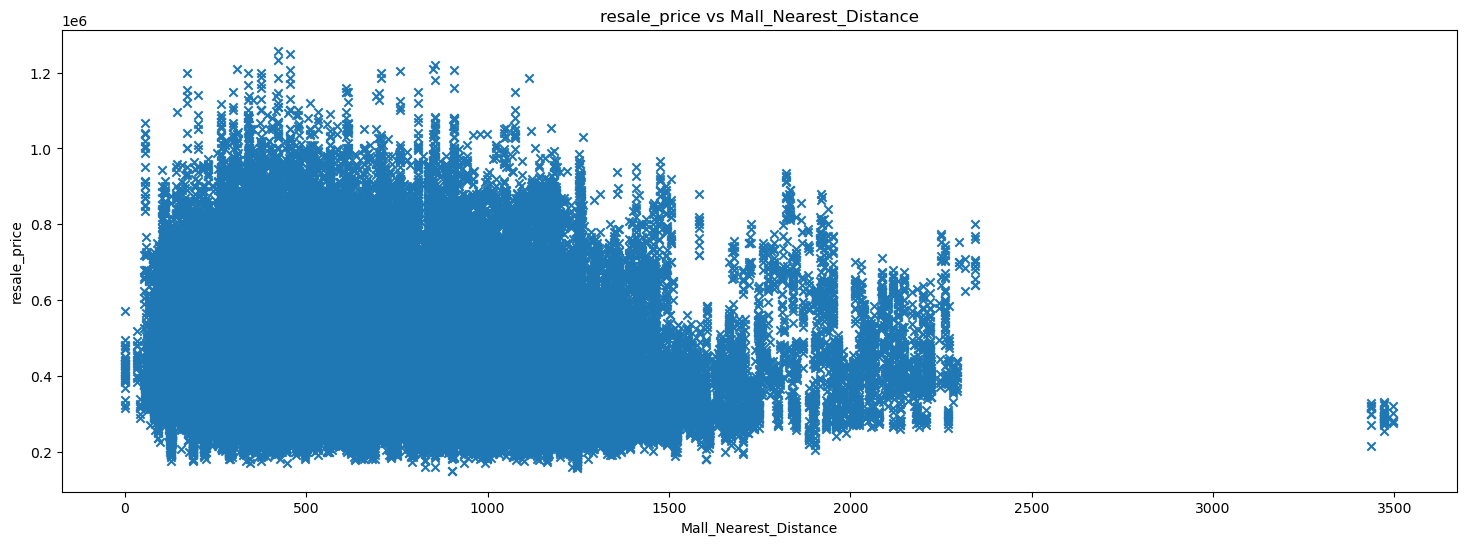

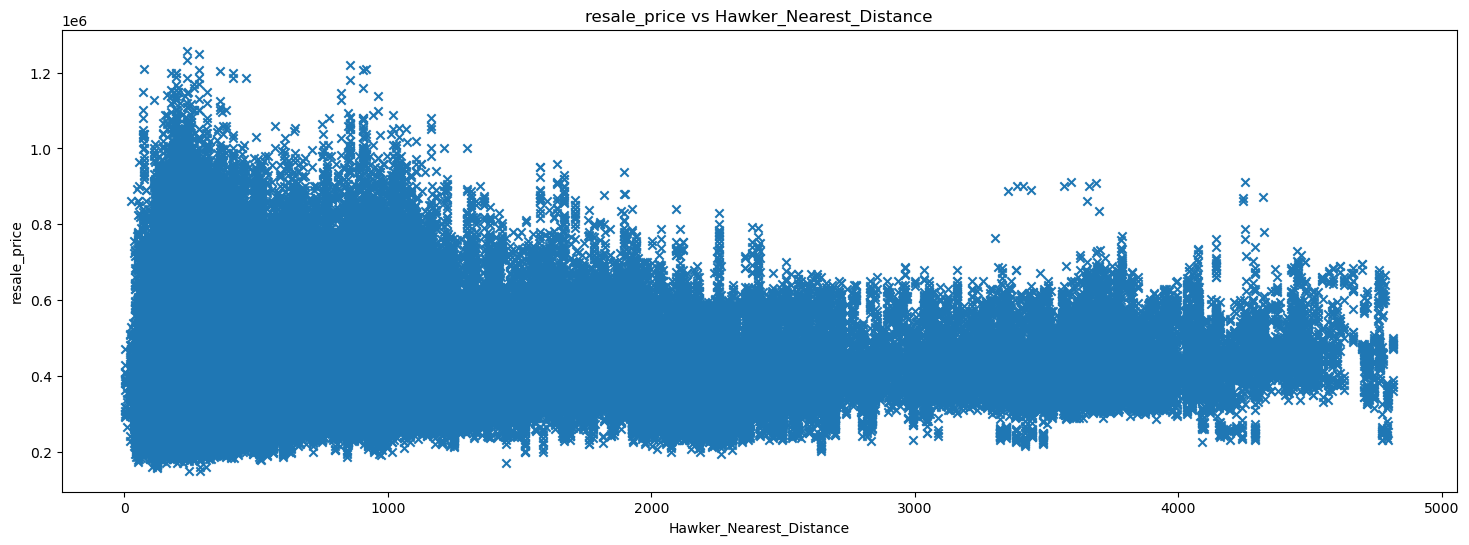

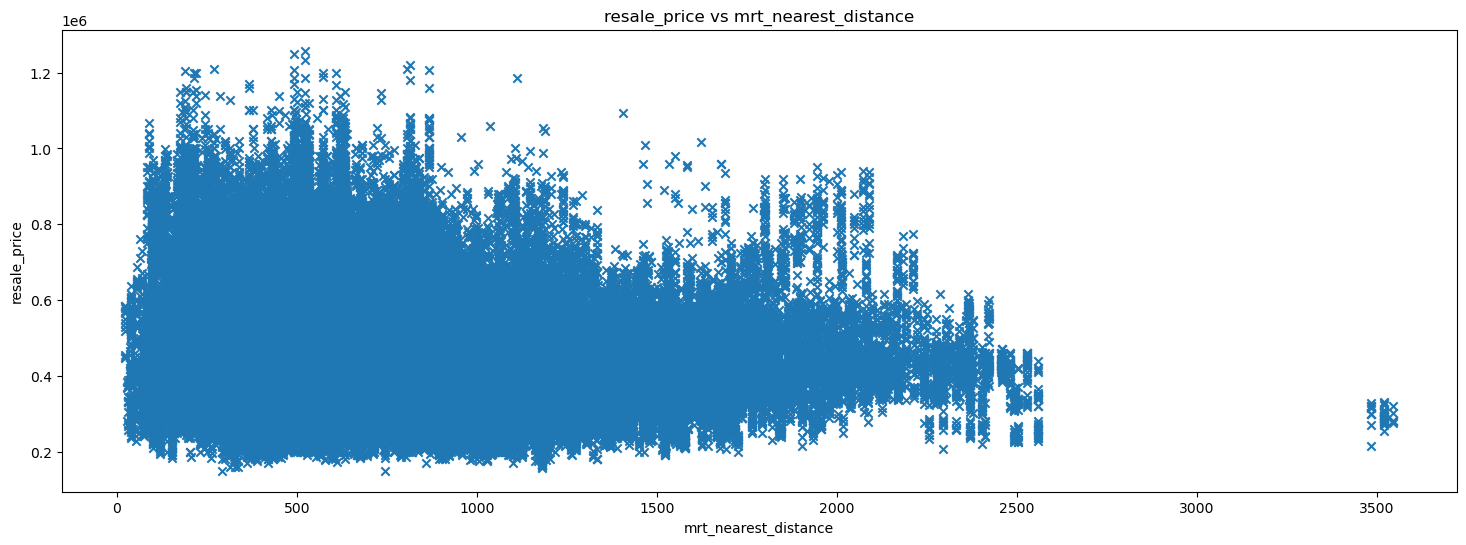

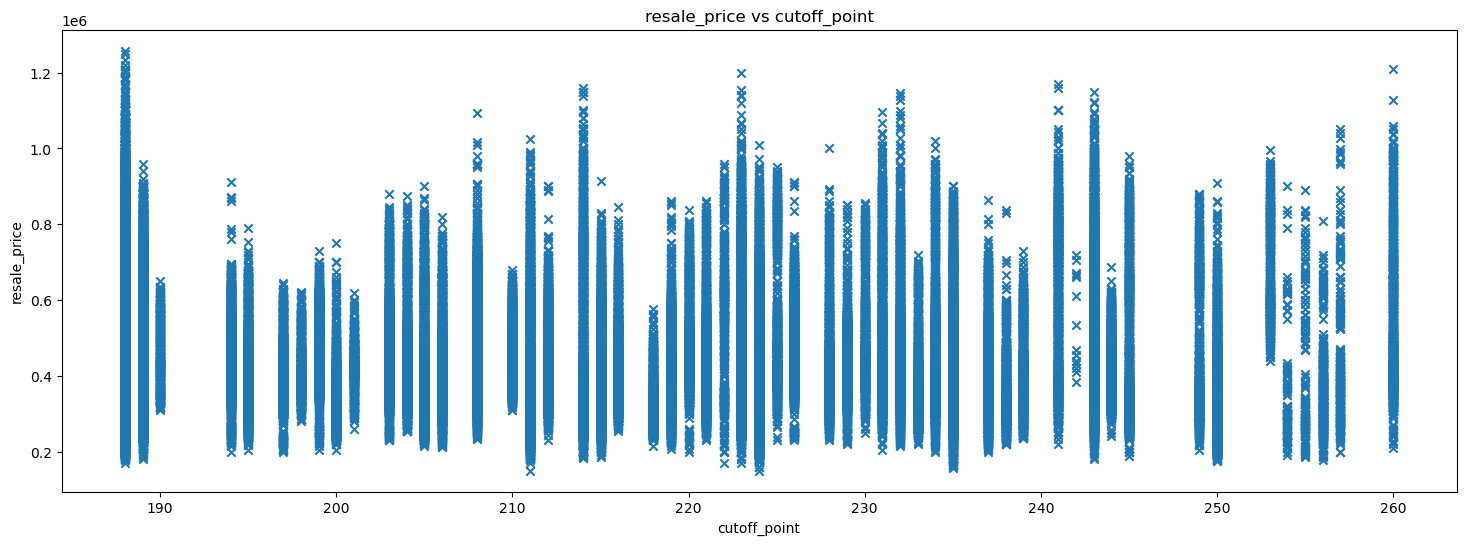

In [48]:
# plot numeric graphs
numeric_columns.plot()

From graphs above, we can see that `floor area` is very correlated to `resale_price`, just as indicated by the correlation matrix.   
This pair have a r value of 0.66.

In [49]:
reduced_train['ln_floor_area'] = np.log(reduced_train.floor_area_sqm)

Text(0.5, 1.0, 'resale_price vs ln_floor_area')

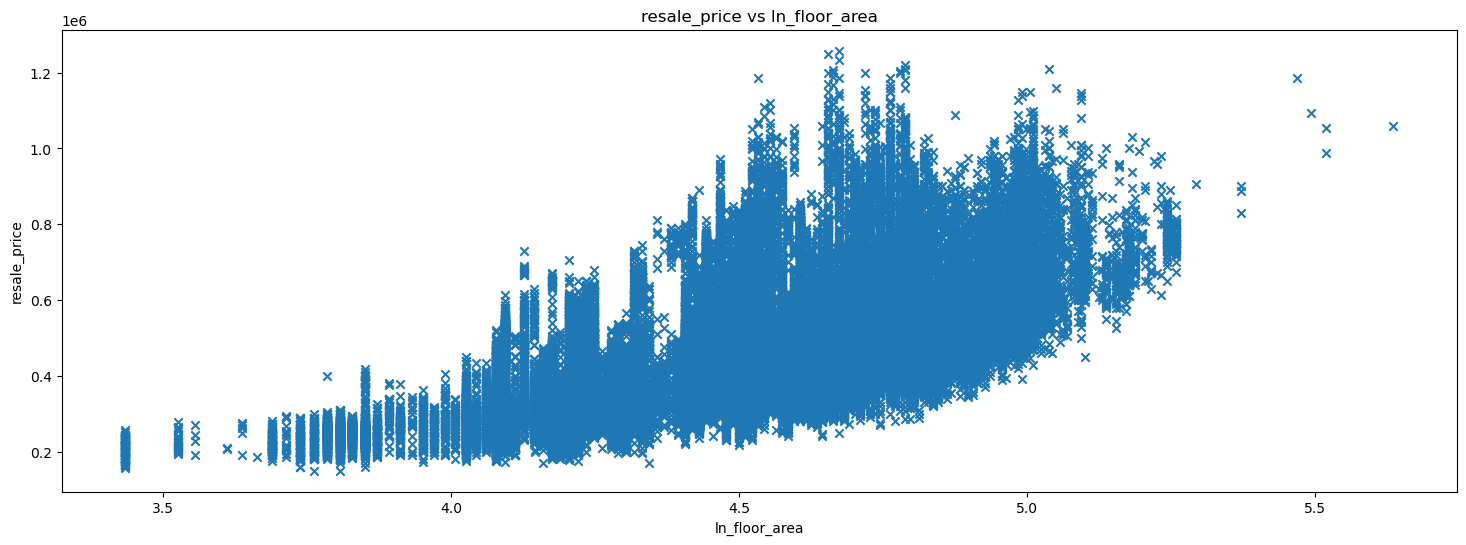

In [50]:
fig = plt.figure(figsize=(18,6)) 
plt.scatter(x=reduced_train['ln_floor_area'], y=reduced_train['resale_price'], marker='x')
plt.xlabel('ln_floor_area')
plt.ylabel('resale_price')
plt.title('resale_price vs ln_floor_area')

In [51]:
reduced_train['ln_floor_area'].corr(reduced_train['resale_price'])

0.6508748437302744

Seems that applying natural log `ln()` to `floor_area` doesn't help.  
Try applying `ln()` to `resale_price`?

0.7054003392959236


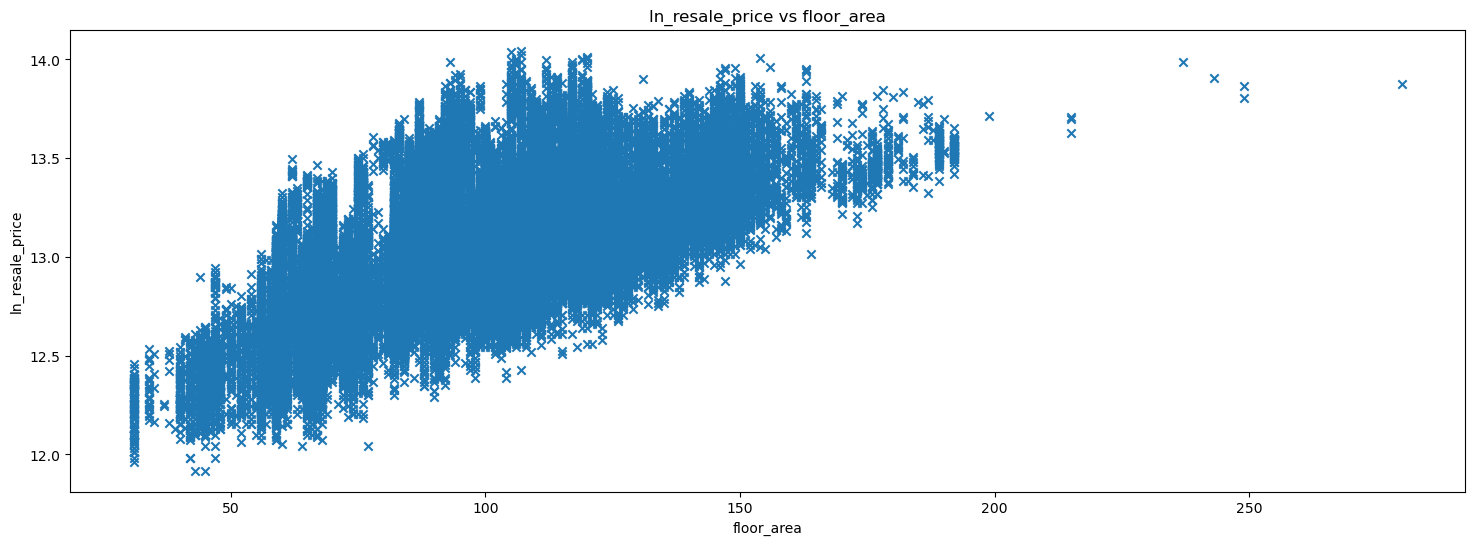

In [52]:
reduced_train['ln_resale_price'] = np.log(reduced_train.resale_price)
fig = plt.figure(figsize=(18,6)) 
plt.scatter(x=reduced_train['floor_area_sqm'], y=reduced_train['ln_resale_price'], marker='x')
plt.xlabel('floor_area')
plt.ylabel('ln_resale_price')
plt.title('ln_resale_price vs floor_area')
print(reduced_train['ln_resale_price'].corr(reduced_train['floor_area_sqm']))

Seeing the r value of 0.7, there's no major improvement.  
Hence, no additional feature engineering will be applied to the numerical columns.  

looking back at the graphs, mrt and mall distance have a small cluster where the flats very far from this 2 places have a very low value.  
This means that we might want to split the data into sections and use different models to predict the prices.  
Other not so obvious, but still obervable clustering also exist in `max_floor_lvl` and `cutoff_point`.  
With this, the EDA on numerical columns are completed.

### Categorical features

This section is all about EDA on categorical features, with summary statistics provided alongside EDA.

In [53]:
# check point to reset
reduced_train = pd.read_csv('../datasets/reduced_train.csv')

In [54]:
# The colmuns that's not in numerical will most likely be categorical
cat_columns = list(reduced_train.columns)
for col in list(numeric_columns.num_columns):
    cat_columns.remove(col)
cat_columns.remove('id')
cat_columns.remove('resale_price')
cat_columns

['flat_type',
 'flat_model',
 'Tranc_Year',
 'planning_area',
 'bus_interchange',
 'mrt_interchange']

In [55]:
class categorical_col(analysis_by_col):
    '''analyse numerical colmuns
    '''
    def __init__(self, df, cat_columns):
        self.cat_columns = cat_columns
        super().__init__(df)
    
    def box_plot(self):
        '''make box plot of categorical features, with 'resale_price' on y axis
        '''
        fig, axes = plt.subplots(len(self.cat_columns), figsize=(30, 60))
        for i, col in enumerate(self.cat_columns):    
            sns.boxplot(data=self.df, x=col, y='resale_price', color="lightblue", ax=axes[i])
            axes[i].set_title('resale_price and '+ col)
    
    def cat_percentage(self, number = False):
        '''find the percentage of data points the category makes up.
        args:
            number (boolean): default = False, if True, display actual number
        '''
        if number:
            for col in self.cat_columns:
                display(reduced_train.groupby(col).count().iloc[:,0])
                print('----------------------------')            
        else:
            for col in self.cat_columns:
                display(round((reduced_train.groupby(col).count().iloc[:,0]/reduced_train.shape[0])*100, 2))
                print('----------------------------')
    
    def cat_countplot(self):
        '''plot the graph of counts of data point in that category.
        '''
        fig, axes = plt.subplots(len(self.cat_columns), figsize=(30, 60))
        for i, col in enumerate(self.cat_columns):    
            sns.countplot(x=self.df[col], ax=axes[i])
            axes[i].set_title('count plot of feature '+ col)    
    
    def average_rasale_dataframe(self, row_feature_name, col_feature_name):
        '''make new dataframe with average resale price based on choice of categorical feature
        args:
            row_feature_name: name of the feature that is to be the row for new dataframe
            col_feature_name: name of the feature that is to be the col for new dataframe
        out:
            df_new: new dataframe with datapoints being average resale price of that category
        Warning:
            resale_price is hard coded, only can be used for this specific dataset
        '''
        columns = self.df[col_feature_name].unique()
        rows = self.df[row_feature_name].unique()
        dict_new = {}
        for col in columns:
            lst = []
            for row in rows:
                val = self.df.loc[(self.df[col_feature_name]==col)&
                                  (self.df[row_feature_name]==row)].mean(numeric_only=True)[2]
                lst.append(val)
            dict_new[col] = lst
        df_new = pd.DataFrame(dict_new, index = rows)
        return df_new

In [56]:
cate_col = categorical_col(reduced_train, cat_columns)

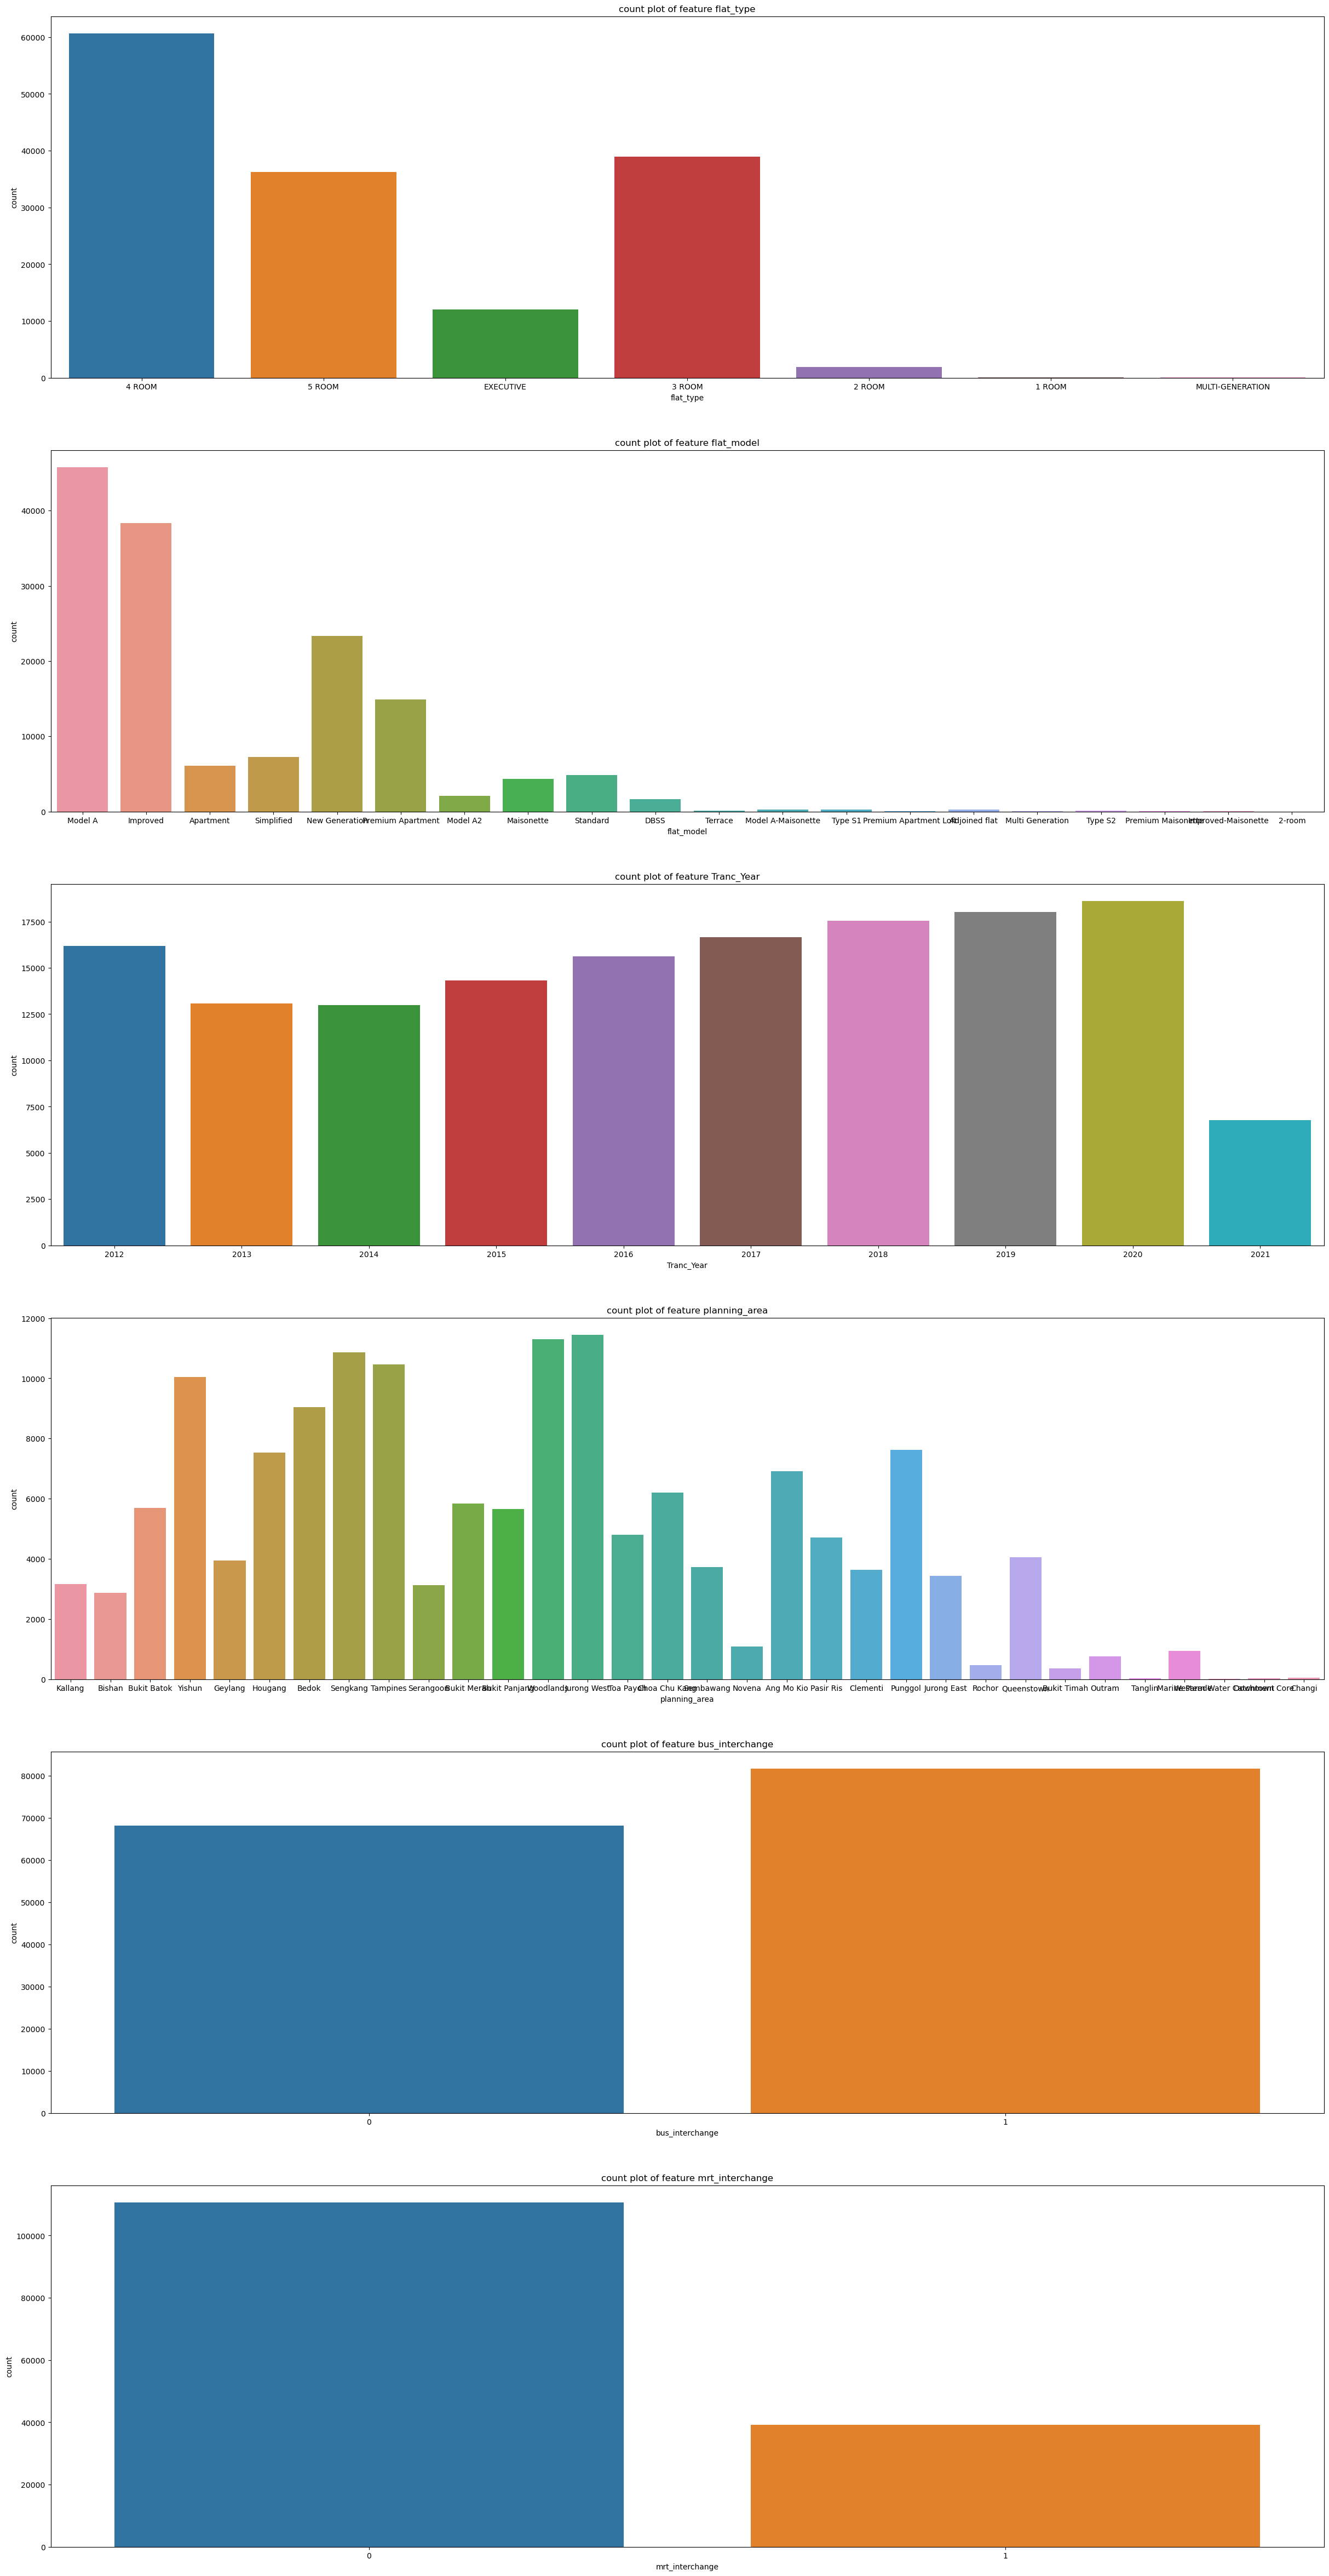

In [57]:
# If you prefer diagram, use this function, else use cat_percentage(), as it is cleaner
cate_col.cat_countplot()

In [58]:
cate_col.cat_percentage()

flat_type
1 ROOM               0.05
2 ROOM               1.26
3 ROOM              25.98
4 ROOM              40.49
5 ROOM              24.18
EXECUTIVE            8.00
MULTI-GENERATION     0.04
Name: id, dtype: float64

----------------------------


flat_model
2-room                     0.00
Adjoined flat              0.17
Apartment                  4.06
DBSS                       1.09
Improved                  25.62
Improved-Maisonette        0.01
Maisonette                 2.91
Model A                   30.56
Model A-Maisonette         0.17
Model A2                   1.38
Multi Generation           0.04
New Generation            15.60
Premium Apartment          9.94
Premium Apartment Loft     0.03
Premium Maisonette         0.01
Simplified                 4.83
Standard                   3.25
Terrace                    0.06
Type S1                    0.16
Type S2                    0.08
Name: id, dtype: float64

----------------------------


Tranc_Year
2012    10.80
2013     8.74
2014     8.67
2015     9.55
2016    10.43
2017    11.13
2018    11.71
2019    12.03
2020    12.43
2021     4.52
Name: id, dtype: float64

----------------------------


planning_area
Ang Mo Kio                 4.61
Bedok                      6.04
Bishan                     1.92
Bukit Batok                3.81
Bukit Merah                3.90
Bukit Panjang              3.78
Bukit Timah                0.24
Changi                     0.03
Choa Chu Kang              4.14
Clementi                   2.42
Downtown Core              0.02
Geylang                    2.64
Hougang                    5.03
Jurong East                2.29
Jurong West                7.64
Kallang                    2.11
Marine Parade              0.63
Novena                     0.73
Outram                     0.51
Pasir Ris                  3.14
Punggol                    5.08
Queenstown                 2.70
Rochor                     0.31
Sembawang                  2.49
Sengkang                   7.26
Serangoon                  2.08
Tampines                   6.99
Tanglin                    0.02
Toa Payoh                  3.21
Western Water Catchment    0.01
Woodlands                 

----------------------------


bus_interchange
0    45.5
1    54.5
Name: id, dtype: float64

----------------------------


mrt_interchange
0    73.87
1    26.13
Name: id, dtype: float64

----------------------------


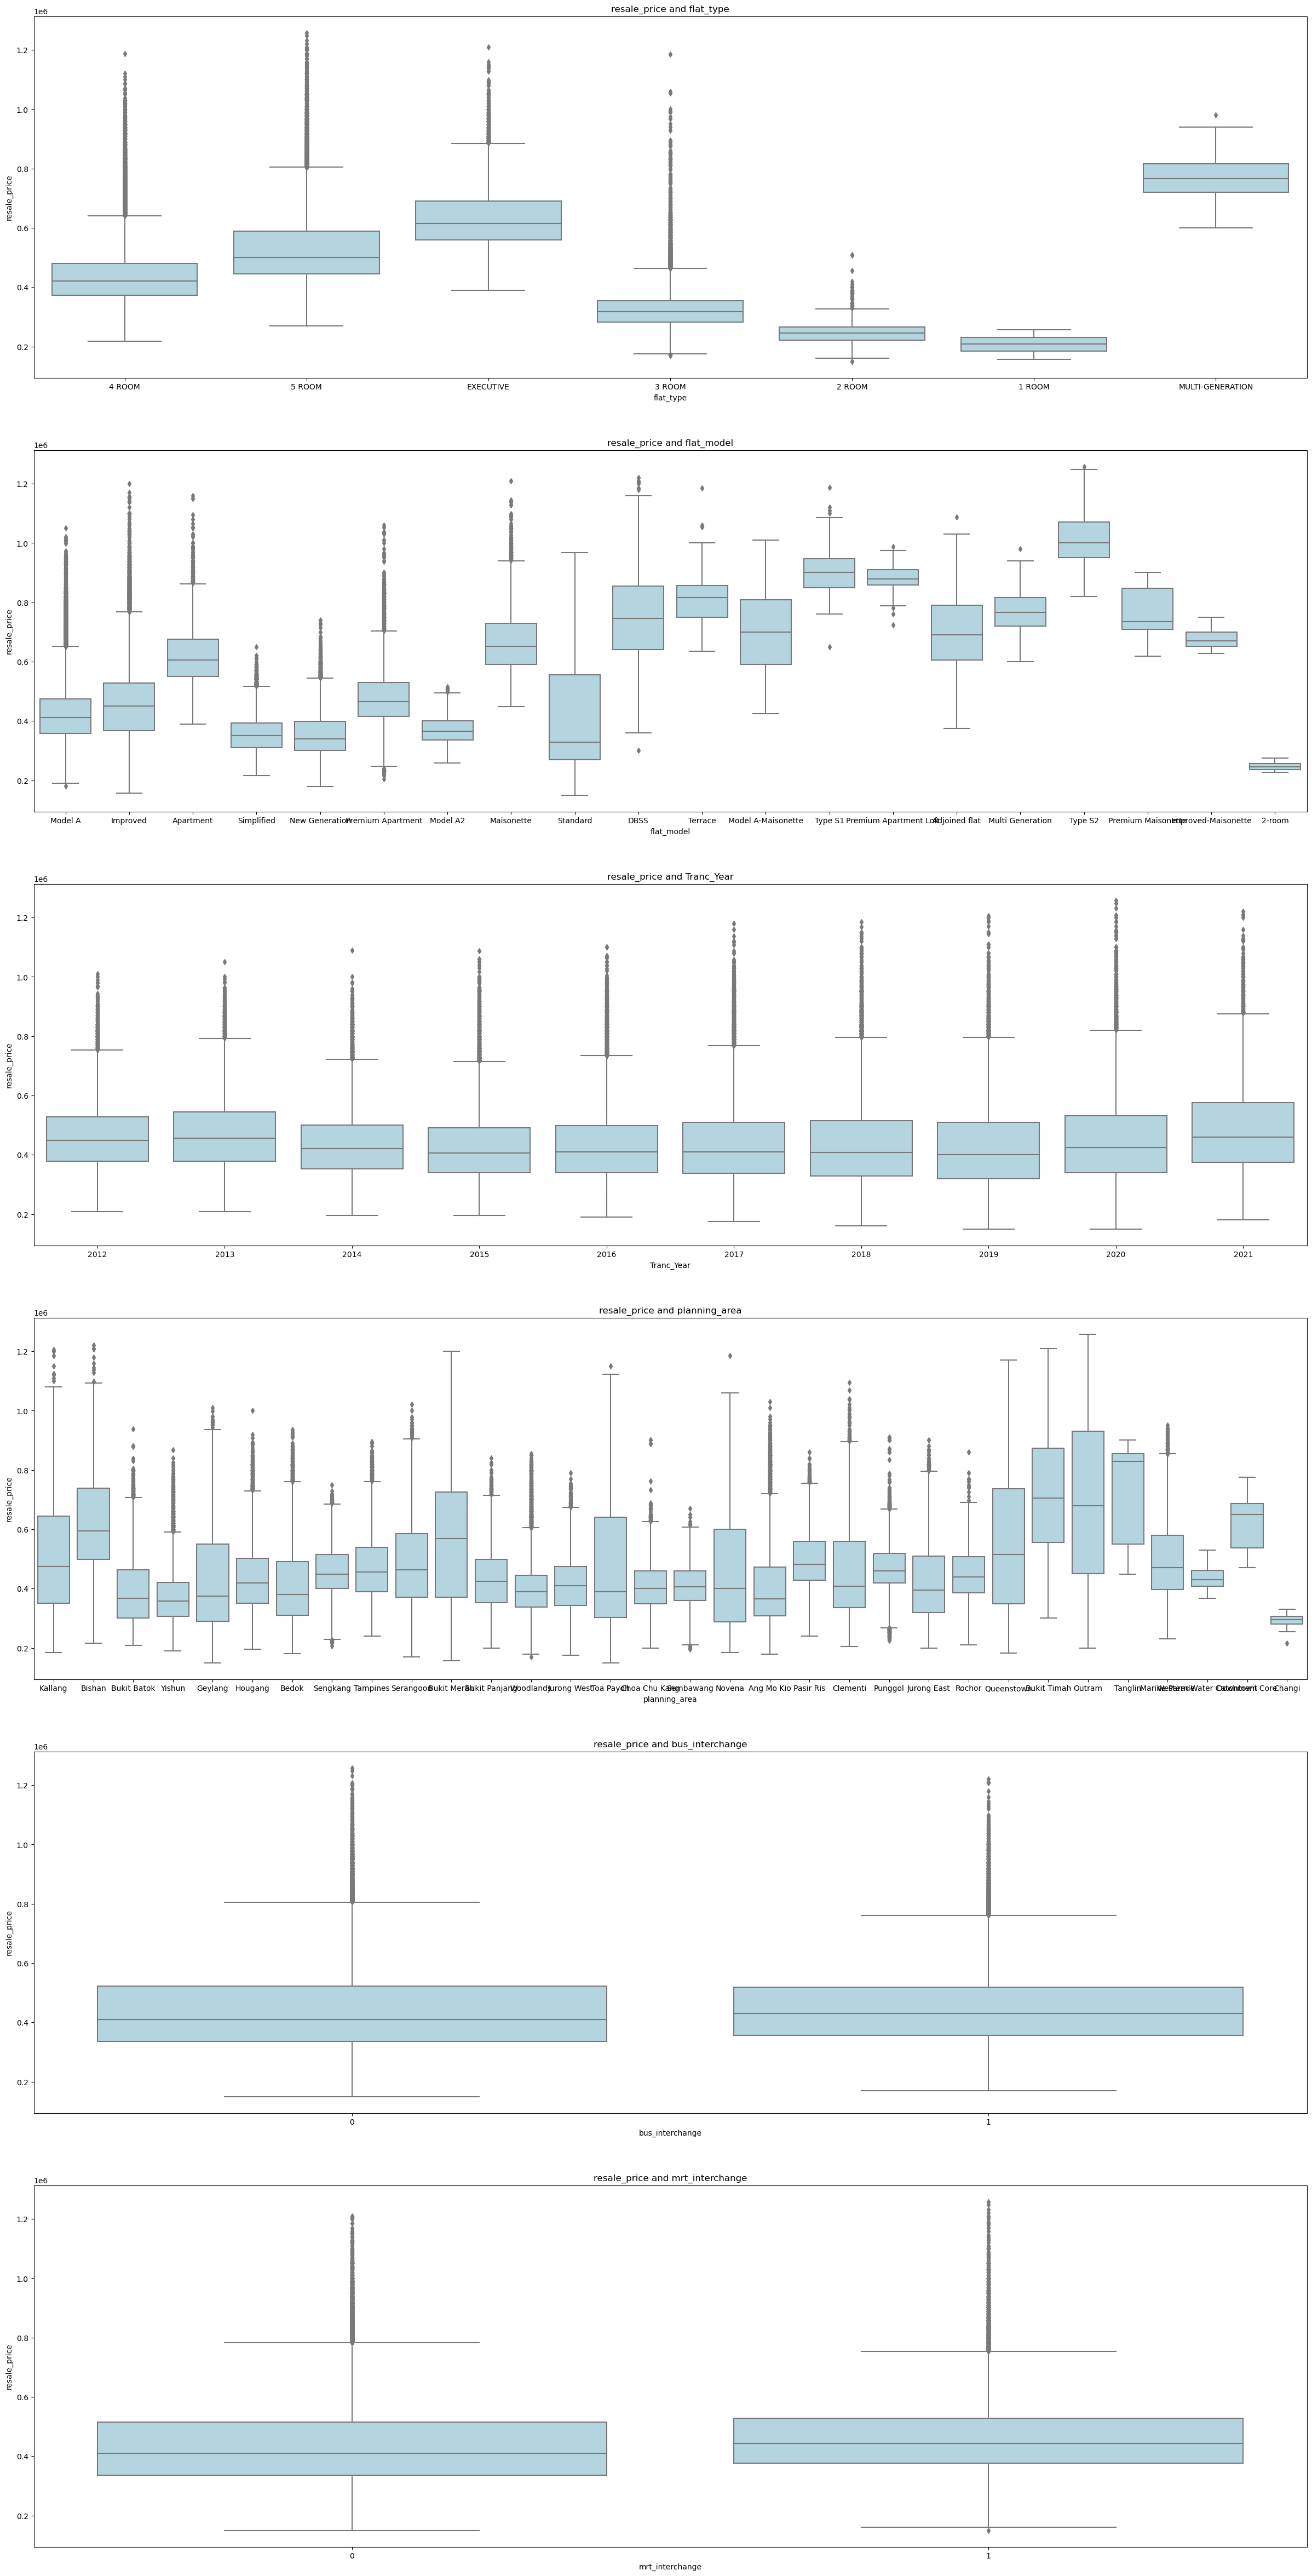

In [59]:
cate_col.box_plot()

Looking at the bar charts above, we can probably tell that `flat_model` will be good for prediction of higher end flats like `Type S1`, `Premium Apartment` etc.  
This is becasue the spread of data shown by the box plot is not as wide as other flat models.  
`flat_type` will perform well for low-end outliers, as `2 ROOM` and `1 ROOM` data are very closely clustered in the box plot.  

Also from the bar charts, we can see that the outliers of each category mainly exist above `Q3 + 1.5 IGR`.  
This may indicate that the higher valued flats will be harder to predict, since they are considered as outliers in the categories.  

Some areas are also clearly more expensive than other on average (median), such as `tanglin`, `bukit timah`, `outram`.  
Places like `changi` is cheaper than other areas.  
Let us take a peak to see how the mean price changed over the years for the more central locations.

In [60]:
new_df = cate_col.average_rasale_dataframe(row_feature_name='Tranc_Year', col_feature_name='planning_area')
new_df

,Kallang,Bishan,Bukit Batok,Yishun,Geylang,Hougang,Bedok,Sengkang,Tampines,Serangoon,Bukit Merah,Bukit Panjang,Woodlands,Jurong West,Toa Payoh,Choa Chu Kang,Sembawang,Novena,Ang Mo Kio,Pasir Ris,Clementi,Punggol,Jurong East,Rochor,Queenstown,Bukit Timah,Outram,Tanglin,Marine Parade,Western Water Catchment,Downtown Core,Changi
2016,548455.576819,619704.903226,389537.724876,366488.803261,422740.455422,417727.623614,411916.925075,439877.165803,455816.204630,478913.947522,543723.453925,407861.526846,398878.907040,406894.976517,440505.264237,393248.754408,409456.306977,427218.935780,418869.829301,477869.653105,441707.588235,452439.349676,426291.267442,453493.000000,552768.879795,690212.200000,715533.825243,546000.000000,506707.377778,NaN,645000.000000,297500.000000
2012,468181.993769,569688.922927,429889.467033,398185.642115,418027.520607,460837.232497,438947.249243,515211.487648,480469.274112,495592.637143,546177.388800,463366.598214,432114.049117,447510.935143,473302.763006,463249.446532,475106.167939,474965.876923,423318.820312,525129.197464,451595.303483,531170.112167,421871.810667,475240.816327,499158.061182,646025.806452,494498.176471,673333.333333,551891.017544,427500.000000,601500.000000,318400.000000
2013,496952.519713,604175.394309,434943.606719,403433.678571,427073.479518,472421.005814,445205.383260,529155.983376,490965.436040,496855.171233,575959.630824,474905.839599,448106.054530,452621.452780,494153.894273,474482.995745,486034.177936,469400.054545,433081.102564,530571.931663,477525.670588,534748.471014,454046.970372,493557.040000,512396.872973,662306.482759,435633.687500,850000.000000,573240.752941,NaN,616500.000000,307250.000000
2017,521748.864407,661245.330556,377094.697479,354575.598039,427908.920879,425417.018531,419316.441885,432402.782784,474399.291391,492783.395137,561324.630323,431000.375224,389415.047116,396498.393755,516433.667208,388911.402821,391107.300469,431021.217391,423005.403670,485812.612705,475640.271233,451949.951426,417183.660000,447299.750000,561212.881545,705702.857143,716878.880000,720000.000000,511761.224490,375000.000000,592857.142857,296833.333333
2018,508836.097826,651508.160494,372023.204074,352902.854069,451673.723118,438231.795673,416170.486631,426760.589359,484058.953509,494146.335917,560683.302460,428756.023451,372212.607872,382066.454751,518604.075085,378601.503937,378630.322650,407022.634921,423281.552239,499231.256048,480326.407125,450940.219532,430383.652709,423517.076923,564831.169355,739470.566038,751290.021053,876500.000000,527250.990291,464333.333333,650333.333333,308333.333333
2020,493939.169329,628877.468144,403212.590106,382270.481295,433518.297483,456597.078201,410286.555450,453936.100472,481093.562219,485720.731707,563032.422047,438135.633909,400238.056912,412270.246389,448656.136194,408845.645862,399040.473829,449334.356190,411312.499379,503184.837070,491143.327660,468283.701930,417864.172589,465754.327273,580570.847149,679050.944444,710581.128205,850000.000000,486928.118812,387000.000000,672500.000000,281950.000000
2014,471441.315412,570345.379310,404877.974757,366761.286464,405564.825737,438270.800303,418223.094760,478931.835705,470360.767398,476532.139860,538380.144348,436467.191344,415032.355511,420316.258272,432643.462103,424607.387119,430506.210191,424567.200000,412174.668760,499904.357488,445502.781646,477563.139535,418615.562701,462234.810811,517732.910997,610925.000000,443396.061224,870000.000000,516986.893805,403500.000000,677500.000000,292500.000000
2015,478850.459228,582838.274590,390557.077686,362439.442029,421176.440000,424169.300265,401781.049793,444776.679787,450311.748593,466806.879257,534042.585462,412646.712946,395006.056237,404586.724079,437411.909502,399785.702786,412393.517157,435664.117647,398049.067143,476767.443064,444062.451031,445327.493230,422125.544073,436457.578947,529235.500000,739191.040000,788288.794326,631666.666667,560134.250000,500000.000000,490000.000000,281250.000000
2019,527302.333333,629518.923077,376671.226389,373182.497297,420906.

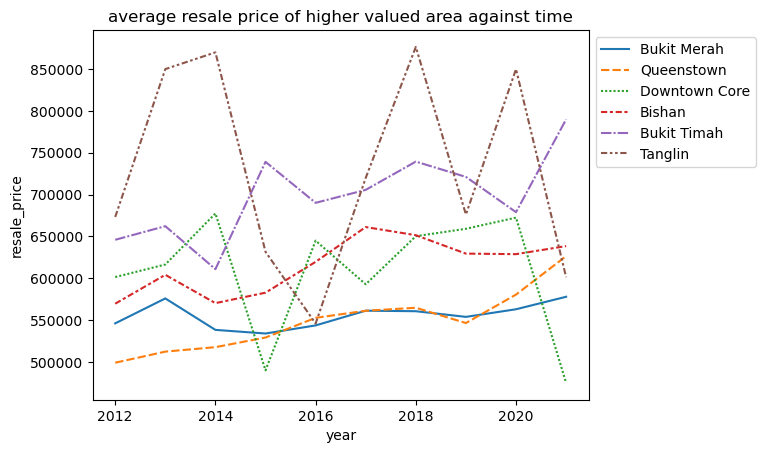

In [61]:
# plot for high valued area
ax = sns.lineplot(data=new_df[['Bukit Merah', 'Queenstown', 'Downtown Core', 'Bishan', 'Bukit Timah', 'Tanglin']],
             legend='auto')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='year', ylabel='resale_price', title='average resale price of higher valued area against time');

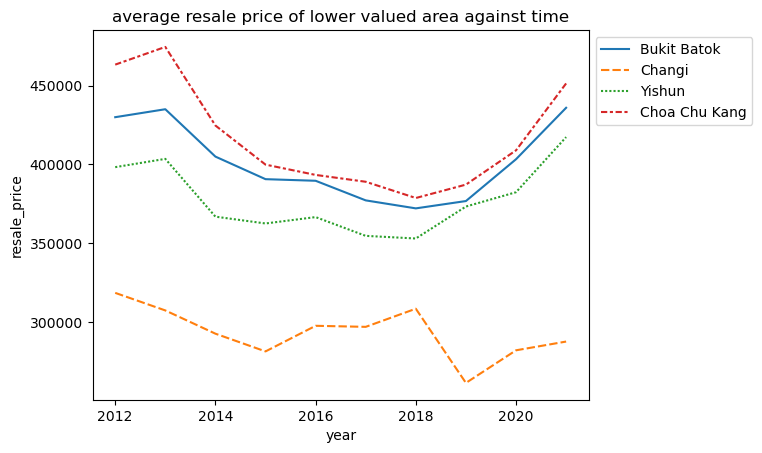

In [62]:
# plot for low valued area
ax = sns.lineplot(data=new_df[['Bukit Batok', 'Changi', 'Yishun', 'Choa Chu Kang']],
             legend='auto')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='year', ylabel='resale_price', title='average resale price of lower valued area against time');

As can be seen from the charts, some areas like those in the first chart have higher values.   
They are usually 500k and above in `resale_price`.   
Some other locations have a lower value, mostly below 450K in terms of `resale_price`.  
This means that we can also consider splitting the data by location.

The function `average_rasale_dataframe` written can also be used to examine other features.  
Which I will not touch on here due to limited time and considerations on length of notebook.  

## Outliers

This section examines the relationship of 'outliers' in some selected features.  
Here, I look at what percentage of data is above or below a specified quantile.  
This is important as this will decide on how to split the data for modelling in the future.  

In [101]:
def find_percentage(df, target, grpby, quantile, tail='two'):
    '''find the percentage of data points in that quantile
    args:
        df: dataframe to look at
        target: target that is used to calculate the quantiles on
        grpby: name of col which the categories are 1st grouped by
        quantile: the quantile too examine
        tail: default = 'two', else 'left' if find lower, 'right' if find higer
    out:
        df: dataframe with categories of col as row index and percentage of that category in the quantile
    '''
    
    if tail == 'two':
        df_outliers = df.loc[(df[target] >= df[target].quantile(q=quantile))|
                             (df[target] <= df[target].quantile(q=1-quantile))]    
    elif tail == 'left':
        df_outliers = df[df[target] <= df[target].quantile(q=quantile)]     
    elif tail == 'right':
        df_outliers = df[df[target] >= df[target].quantile(q=quantile)]
    
    info_by_feature = {}
    outliers_info = {}
    df_grouped = df.groupby(grpby)[target].describe().sort_values('mean')
    
    for feature, count, mean in zip(df_grouped.index, df_grouped['count'], df_grouped['mean']):
        info_by_feature[feature] = [count, mean]
        
    df_outliers = df_outliers.groupby(grpby)[target].describe().sort_values('mean')
    
    for feature, count, mean in zip(df_outliers.index, df_outliers['count'], df_outliers['mean']):
        outliers_info[feature] = [count, mean]
        
    percentage = {}
        
    for feature in outliers_info.keys():
        percentage[feature] = np.round(outliers_info[feature][0]/info_by_feature[feature][0]*100, 2)
        
    return pd.DataFrame(percentage.values(), index=percentage.keys(), columns=['percentage']).sort_values('percentage', ascending=False)

In [102]:
find_percentage(df = reduced_train, target='resale_price', grpby='flat_model', quantile=0.9, tail='right')

,percentage
Type S2,100.00
Type S1,100.00
Premium Apartment Loft,100.00
Terrace,97.89
Multi Generation,96.43
Premium Maisonette,86.67
Improved-Maisonette,73.68
DBSS,73.58
Adjoined flat,64.62
Model A-Maisonette,62.21


This shows that `Type S2`, `Type S1` etc are very expensive flats.  
This information can help to decide how best to split the dataset when building model later.  

Another example is using the planning area.

In [106]:
find_percentage(df = reduced_train, target='resale_price', grpby='planning_area', quantile=0.95, tail='right')

,percentage
Tanglin,52.00
Outram,49.01
Bukit Timah,44.20
Bishan,25.57
Queenstown,25.54
Bukit Merah,23.24
Marine Parade,19.62
Toa Payoh,15.84
Kallang,12.44
Clementi,10.42


The top 6 categories probably can be thier own class.  
The same goes with the bottom few.

## Evaluation based on EDA

In this notebook, a very through EDA is performed.   
I started by looking for the missing values and imputing them.  
I then moved on to examining the appropriate values to use for prediction.  
After determining the appropriate values to use, I split the data into numerical and categorical data.  
I examined both of these data closely and throughly, with various forms of summary statistics provided.
The distributions are also examined carefully.  
Outliers are indentified and examined.  

A through EDA is done on the dataset provided, with all the above steps completed.  
I feel that the data is more than sufficient to answer the problem statement, which is to predict the resale price using regression.  